# Modelling for predicting match results from past performance with a rolling window

Dependencies

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

Data as prepared in relevant notebooks and saved as pickle.

In [2]:
df_main = pd.read_pickle("../data/processed/rolling_performance.pkl")
df_main.info() ; df_main.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33907 entries, 0 to 33906
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   date                              33907 non-null  datetime64[ns]
 1   home_team                         33907 non-null  object        
 2   away_team                         33907 non-null  object        
 3   home_score                        33907 non-null  int64         
 4   away_score                        33907 non-null  int64         
 5   tournament                        33907 non-null  object        
 6   city                              33907 non-null  object        
 7   country                           33907 non-null  object        
 8   neutral                           33907 non-null  bool          
 9   match_id                          33907 non-null  int64         
 10  home_win_ratio_roll183D           33907 non-nu

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,match_id,...,away_win_ratio_roll548D,away_draw_ratio_roll548D,away_avg_goals_scored_roll548D,away_avg_goals_conceded_roll548D,away_win_ratio_roll730D,away_draw_ratio_roll730D,away_avg_goals_scored_roll730D,away_avg_goals_conceded_roll730D,host_advantage,result
0,1975-01-01,Cameroon,Guinea,1,0,Friendly,Yaoundé,Cameroon,False,870,...,0.111111,0.444444,1.222222,2.111111,0.277778,0.388889,1.611111,1.777778,Yes,home_win
1,1975-01-01,Iraq,Tunisia,0,0,Friendly,Baghdad,Iraq,False,871,...,0.647059,0.058824,1.647059,0.941176,0.523810,0.095238,1.476190,1.333333,Yes,draw
2,1975-01-03,Bermuda,Suriname,2,5,Friendly,Hamilton,Bermuda,False,872,...,0.444444,0.333333,1.666667,1.111111,0.444444,0.333333,1.666667,1.111111,Yes,away_win
3,1975-01-09,Iraq,Libya,3,1,Friendly,Baghdad,Iraq,False,874,...,0.466667,0.266667,2.066667,1.000000,0.466667,0.266667,2.066667,1.000000,Yes,home_win
4,1975-01-14,Kuwait,Libya,1,0,Friendly,Kuwait City,Kuwait,False,875,...,0.437500,0.250000,2.000000,1.125000,0.437500,0.250000,2.000000,1.125000,Yes,home_win


## Preparing training and test sets

We will look at Euro 24 separately. So we focus on results before Euro 24.

In [3]:
df_main = df_main[df_main["date"] < datetime(2024, 6, 14)].copy()
df_main.tail()

We will check the predictive power of different windows. We organise feature column names according to these rolling windows.

In [14]:
train_col_names = {}

for window in ["roll183D", "roll365D", "roll548D", "roll730D"]:
    col_names = []
    for ha in ["home", "away"]:
        for metric in ["win_ratio", "draw_ratio", "avg_goals_scored", "avg_goals_conceded"]:
            col_names.append(f"{ha}_{metric}_{window}")
    train_col_names[window] = col_names

train_col_names_all = []

for col_names in train_col_names.values():
    train_col_names_all += col_names

for window in train_col_names:
    train_col_names[window].append("host_advantage")

train_col_names_all.append("host_advantage")

We want to optimise the models for predicting new results from historical information. So the train-test split will be made at a certain point in time, rather than randomly. To define a cut-off, let's check the number of matches per year.

In [19]:
df_main["year"] = df_main["date"].dt.year
df_main.value_counts("year", sort = False).sort_index(ascending = False).cumsum()

year
2024      490
2023     1471
2022     2381
2021     3441
2020     3704
2019     4794
2018     5643
2017     6505
2016     7373
2015     8335
2014     9100
2013    10015
2012    10966
2011    12011
2010    12784
2009    13644
2008    14674
2007    15600
2006    16353
2005    17096
2004    18116
2003    18987
2002    19653
2001    20614
2000    21564
1999    22262
1998    22931
1997    23779
1996    24547
1995    25143
1994    25669
1993    26391
1992    26893
1991    27328
1990    27735
1989    28291
1988    28747
1987    29067
1986    29438
1985    29982
1984    30436
1983    30823
1982    31183
1981    31637
1980    32073
1979    32428
1978    32748
1977    33154
1976    33474
1975    33807
Name: count, dtype: int64

2020 was a special year with relatively few games. Starting with 2021 will give about 3500 observations for testing, about 10%.

In [20]:
df_test = df_main[df_main["year"] > 2020].copy()
df_train = df_main[df_main["year"] <= 2020].copy()

Separate the target and features, for each window, as well as all windows

In [21]:
y_train = df_train[["result"]] ; y_test = df_test[["result"]]
X_train = df_train[train_col_names_all] ; X_test = df_test[train_col_names_all]
X_train_183 = df_train[train_col_names["roll183D"]] ; X_test_183 = df_test[train_col_names["roll183D"]]
X_train_365 = df_train[train_col_names["roll365D"]] ; X_test_365 = df_test[train_col_names["roll365D"]]
X_train_548 = df_train[train_col_names["roll548D"]] ; X_test_548 = df_test[train_col_names["roll548D"]]
X_train_730 = df_train[train_col_names["roll730D"]] ; X_test_730 = df_test[train_col_names["roll730D"]]

## Comparing potential models with all windows

We set up a pycaret workflow to compare possible classification models. We apply a time series logic in the setup, in line withe the train-test split. For initial model selection, we use features from all windows.

In [22]:
from pycaret.classification import *

In [23]:
clf = setup(
    data = pd.concat([X_train, y_train], axis = 1),
    target = "result",
    session_id = 42, 
    test_data = pd.concat([X_test, y_test], axis = 1),
    experiment_name = "rolling_model_all_windows",
    n_jobs = -1, 
    train_size = 0.8, 
    fix_imbalance = True,
    normalize = True, 
    data_split_shuffle = False, 
    fold_shuffle = False, 
    fold_strategy = "timeseries"
)

,Description,Value
0,Session id,42
1,Target,result
2,Target type,Multiclass
3,Target mapping,"away_win: 0, draw: 1, home_win: 2"
4,Original data shape,"(33807, 34)"
5,Transformed data shape,"(46353, 34)"
6,Transformed train set shape,"(42912, 34)"
7,Transformed test set shape,"(3441, 34)"
8,Numeric features,32
9,Categorical features,1


Let's base the model selection on F1 to achieve a balance between precision and recall.

In [24]:
model_selection = compare_models(sort = "f1", exclude = ["lightgbm", "catboost"]) # exclude lightgbm and catboost because they are too slow

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.4962,0.0000,0.4962,0.4970,0.4929,0.2156,0.2173,0.1700
lr,Logistic Regression,0.4861,0.0000,0.4861,0.5044,0.4919,0.2115,0.2129,0.6490
gbc,Gradient Boosting Classifier,0.4964,0.0000,0.4964,0.4887,0.4909,0.2062,0.2070,15.9540
lda,Linear Discriminant Analysis,0.4805,0.0000,0.4805,0.5084,0.4894,0.2086,0.2110,0.2330
et,Extra Trees Classifier,0.4977,0.6575,0.4977,0.4767,0.4839,0.1925,0.1942,1.5980
rf,Random Forest Classifier,0.4917,0.6553,0.4917,0.4785,0.4837,0.1919,0.1926,2.5610
ada,Ada Boost Classifier,0.4735,0.0000,0.4735,0.4871,0.4780,0.1878,0.1888,1.1530
xgboost,Extreme Gradient Boosting,0.4864,0.6457,0.4864,0.4699,0.4755,0.1772,0.1786,1.4470
svm,SVM - Linear Kernel,0.4928,0.0000,0.4928,0.4701,0.4665,0.1933,0.2003,0.4690
nb,Naive Bayes,0.4071,0.6571,0.4071,0.5385,0.4132,0.1497,0.1767,0.1830


Let's proceed with two top results: ridge and LR.

### Hyperparameter tuning for ridge regression

In [29]:
model_ridge = create_model("ridge")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4366,0.0000,0.4366,0.4618,0.4434,0.1499,0.1519
1,0.4703,0.0000,0.4703,0.4840,0.4736,0.1964,0.1978
2,0.5272,0.0000,0.5272,0.5237,0.5200,0.2519,0.2550
3,0.5159,0.0000,0.5159,0.5076,0.5083,0.2360,0.2378
4,0.5000,0.0000,0.5000,0.4950,0.4960,0.2174,0.2181
5,0.4967,0.0000,0.4967,0.4943,0.4911,0.2128,0.2150
6,0.5174,0.0000,0.5174,0.5175,0.5149,0.2461,0.2475
7,0.4899,0.0000,0.4899,0.4888,0.4861,0.2047,0.2063
8,0.5134,0.0000,0.5134,0.5068,0.5072,0.2308,0.2323


In [30]:
model_ridge_tuned = tune_model(
    model_ridge,
    optimize = "f1", 
    search_library = "scikit-learn",
    search_algorithm = "grid", 
    custom_grid = {
        "alpha": np.logspace(-2, 2, 21).tolist()
    }, 
    fold = 10
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4348,0.0000,0.4348,0.4588,0.4412,0.1465,0.1483
1,0.4678,0.0000,0.4678,0.4822,0.4713,0.1932,0.1947
2,0.5283,0.0000,0.5283,0.5230,0.5202,0.2527,0.2558
3,0.5159,0.0000,0.5159,0.5077,0.5081,0.2358,0.2377
4,0.4993,0.0000,0.4993,0.4942,0.4952,0.2161,0.2168
5,0.4975,0.0000,0.4975,0.4961,0.4924,0.2145,0.2167
6,0.5188,0.0000,0.5188,0.5184,0.5160,0.2478,0.2493
7,0.4917,0.0000,0.4917,0.4908,0.4879,0.2077,0.2093
8,0.5134,0.0000,0.5134,0.5072,0.5074,0.2311,0.2326


Fitting 10 folds for each of 21 candidates, totalling 210 fits


### Hyperparameter tuning for logistic regression

In [31]:
model_lr = create_model("lr")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4272,0.0000,0.4272,0.4640,0.4368,0.1419,0.1447
1,0.4620,0.0000,0.4620,0.4867,0.4692,0.1890,0.1912
2,0.5105,0.0000,0.5105,0.5277,0.5154,0.2404,0.2423
3,0.5076,0.0000,0.5076,0.5123,0.5087,0.2323,0.2329
4,0.4949,0.0000,0.4949,0.5079,0.5003,0.2211,0.2217
5,0.4920,0.0000,0.4920,0.5068,0.4966,0.2160,0.2173
6,0.5047,0.0000,0.5047,0.5308,0.5140,0.2425,0.2445
7,0.4736,0.0000,0.4736,0.4933,0.4800,0.1938,0.1953
8,0.4942,0.0000,0.4942,0.5092,0.5000,0.2158,0.2167


In [32]:
model_lr_tuned = tune_model(
    model_lr,
    optimize = "f1", 
    search_library = "scikit-learn",
    search_algorithm = "grid", 
    custom_grid = {
        "penalty": ["l1", "l2"],
        "C": np.logspace(-2, 2, 21).tolist(),
        "solver" : ["liblinear"]
    }, 
    fold = 10
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4351,0.0000,0.4351,0.4648,0.4432,0.1501,0.1524
1,0.4710,0.0000,0.4710,0.4883,0.4759,0.1993,0.2009
2,0.5196,0.0000,0.5196,0.5240,0.5178,0.2466,0.2487
3,0.5109,0.0000,0.5109,0.5083,0.5073,0.2327,0.2338
4,0.5014,0.0000,0.5014,0.5030,0.5014,0.2242,0.2246
5,0.5043,0.0000,0.5043,0.5071,0.5021,0.2277,0.2295
6,0.5127,0.0000,0.5127,0.5230,0.5158,0.2452,0.2463
7,0.4880,0.0000,0.4880,0.4945,0.4890,0.2066,0.2077
8,0.5062,0.0000,0.5062,0.5072,0.5054,0.2247,0.2254


Fitting 10 folds for each of 42 candidates, totalling 420 fits


Based on these results, we will proceed with logistic regression.

### Feature selection

In [33]:
evaluate_model(model_lr_tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Based on feature importances, the window of 730 days appears to be the time frame where past performance provides the best predictions.

## Comparing potential models with the window of 730 days

In [34]:
clf_w730 = setup(
    data = pd.concat([X_train_730, y_train], axis = 1),
    target = "result",
    session_id = 42, 
    test_data = pd.concat([X_test_730, y_test], axis = 1),
    experiment_name = "rolling_model_window730",
    n_jobs = -1, 
    train_size = 0.8, 
    fix_imbalance = True,
    normalize = True, 
    data_split_shuffle = False, 
    fold_shuffle = False, 
    fold_strategy = "timeseries"
)

,Description,Value
0,Session id,42
1,Target,result
2,Target type,Multiclass
3,Target mapping,"away_win: 0, draw: 1, home_win: 2"
4,Original data shape,"(33807, 10)"
5,Transformed data shape,"(46353, 10)"
6,Transformed train set shape,"(42912, 10)"
7,Transformed test set shape,"(3441, 10)"
8,Numeric features,8
9,Categorical features,1


In [35]:
model_selection_w730 = compare_models(sort = "f1", exclude = ["lightgbm", "catboost"])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.4885,0.0000,0.4885,0.5015,0.4926,0.2107,0.2118,4.6160
ridge,Ridge Classifier,0.4971,0.0000,0.4971,0.4949,0.4921,0.2147,0.2167,0.0950
lr,Logistic Regression,0.4867,0.0000,0.4867,0.5031,0.4920,0.2108,0.2121,0.1390
lda,Linear Discriminant Analysis,0.4807,0.0000,0.4807,0.5079,0.4893,0.2081,0.2104,0.1220
ada,Ada Boost Classifier,0.4782,0.0000,0.4782,0.5012,0.4856,0.2018,0.2037,0.4710
rf,Random Forest Classifier,0.4809,0.6490,0.4809,0.4757,0.4777,0.1826,0.1829,1.5170
et,Extra Trees Classifier,0.4846,0.6487,0.4846,0.4713,0.4765,0.1797,0.1804,1.0700
xgboost,Extreme Gradient Boosting,0.4733,0.6468,0.4733,0.4758,0.4741,0.1764,0.1766,0.7300
svm,SVM - Linear Kernel,0.4960,0.0000,0.4960,0.4758,0.4737,0.1968,0.2027,0.1750
nb,Naive Bayes,0.4133,0.6668,0.4133,0.5466,0.4206,0.1589,0.1870,0.1020


### Hyperparameter tuning for gradient boosting classifier

In [36]:
model_gbc_w730 = create_model("gbc")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4420,0.0000,0.4420,0.4701,0.4511,0.1565,0.1584
1,0.4830,0.0000,0.4830,0.4956,0.4881,0.2073,0.2079
2,0.4986,0.0000,0.4986,0.5115,0.4996,0.2214,0.2241
3,0.4913,0.0000,0.4913,0.5020,0.4946,0.2126,0.2135
4,0.4873,0.0000,0.4873,0.4985,0.4922,0.2074,0.2078
5,0.5098,0.0000,0.5098,0.5182,0.5128,0.2381,0.2387
6,0.4978,0.0000,0.4978,0.5166,0.5045,0.2277,0.2290
7,0.4851,0.0000,0.4851,0.5045,0.4914,0.2112,0.2128
8,0.4982,0.0000,0.4982,0.5057,0.5008,0.2170,0.2175


In [37]:
model_gbc_w730_tuned = tune_model(
    model_gbc_w730,
    optimize = "f1", 
    search_library = "scikit-optimize",
    search_algorithm = "bayesian", 
    custom_grid = {
        "n_estimators": [50, 100, 250, 500, 1000],
        "learning_rate" : [0.001, 0.01, 0.1, 1.0],
        "subsample" : [0.5, 0.8, 1.0], 
        "min_samples_split": np.linspace(2, 66, 17).astype(int),
        "min_samples_leaf": np.linspace(1, 33, 17).astype(int),
        "max_depth": np.linspace(4, 40, 19).astype(int), 
        "max_features": ["sqrt", "log2"]
    }, 
    fold = 5,
    n_iter = 10
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4764,0.0000,0.4764,0.4786,0.4771,0.1884,0.1886
1,0.5017,0.0000,0.5017,0.5019,0.5007,0.2210,0.2215
2,0.5031,0.0000,0.5031,0.4996,0.5007,0.2148,0.2151
3,0.4794,0.0000,0.4794,0.4875,0.4822,0.1953,0.1958
4,0.4991,0.0000,0.4991,0.4920,0.4948,0.2097,0.2101
Mean,0.4919,0.0000,0.4919,0.4919,0.4911,0.2059,0.2062
Std,0.0116,0.0000,0.0116,0.0084,0.0097,0.0122,0.0122


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Hyperparameter tuning for logistic regression

In [38]:
model_lr_w730 = create_model("lr")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4413,0.0000,0.4413,0.4749,0.4511,0.1595,0.1621
1,0.4652,0.0000,0.4652,0.4861,0.4720,0.1905,0.1920
2,0.5145,0.0000,0.5145,0.5261,0.5159,0.2433,0.2456
3,0.5047,0.0000,0.5047,0.5120,0.5071,0.2294,0.2300
4,0.4880,0.0000,0.4880,0.5000,0.4931,0.2098,0.2103
5,0.4931,0.0000,0.4931,0.5079,0.4977,0.2174,0.2187
6,0.5025,0.0000,0.5025,0.5259,0.5113,0.2371,0.2386
7,0.4750,0.0000,0.4750,0.4938,0.4814,0.1949,0.1962
8,0.4975,0.0000,0.4975,0.5101,0.5023,0.2193,0.2200


In [39]:
model_lr_w730_tuned = tune_model(
    model_lr_w730, 
    optimize = "f1",
    search_library = "scikit-optimize",
    search_algorithm = "bayesian", 
    custom_grid = {
        "penalty": ["elasticnet"],
        "C": np.logspace(-2, 2, 21).tolist(),
        "l1_ratio" : np.linspace(0, 1, 11).tolist(),
        "solver" : ["saga"], 
        "class_weight" : ["balanced", None]
    }, 
    fold = 10, 
    n_iter = 50
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4457,0.0000,0.4457,0.4770,0.4549,0.1649,0.1674
1,0.4696,0.0000,0.4696,0.4896,0.4760,0.1968,0.1984
2,0.5163,0.0000,0.5163,0.5263,0.5172,0.2449,0.2471
3,0.5043,0.0000,0.5043,0.5114,0.5066,0.2287,0.2294
4,0.4870,0.0000,0.4870,0.4985,0.4918,0.2079,0.2083
5,0.4964,0.0000,0.4964,0.5114,0.5010,0.2227,0.2241
6,0.5040,0.0000,0.5040,0.5263,0.5123,0.2387,0.2402
7,0.4736,0.0000,0.4736,0.4917,0.4798,0.1922,0.1935
8,0.4982,0.0000,0.4982,0.5114,0.5032,0.2208,0.2216


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

In [40]:
model_lr_w730_tuned_2 = tune_model(
    model_lr_w730, 
    optimize = "f1",
    search_library = "scikit-learn",
    search_algorithm = "grid", 
    custom_grid = {
        "penalty": ["l1", "l2"],
        "C": np.logspace(-2, 2, 21).tolist(),
        "solver" : ["liblinear"], 
        "class_weight" : ["balanced", None]
    }, 
    fold = 10
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4623,0.0000,0.4623,0.4634,0.4597,0.1726,0.1739
1,0.4804,0.0000,0.4804,0.4832,0.4798,0.2035,0.2043
2,0.5272,0.0000,0.5272,0.5210,0.5179,0.2497,0.2532
3,0.5112,0.0000,0.5112,0.5035,0.5038,0.2283,0.2301
4,0.4895,0.0000,0.4895,0.4873,0.4876,0.2027,0.2031
5,0.4996,0.0000,0.4996,0.5013,0.4969,0.2195,0.2214
6,0.5159,0.0000,0.5159,0.5224,0.5170,0.2483,0.2495
7,0.4841,0.0000,0.4841,0.4861,0.4827,0.1977,0.1987
8,0.5058,0.0000,0.5058,0.5052,0.5037,0.2228,0.2237


Fitting 10 folds for each of 84 candidates, totalling 840 fits


### Hyperparameter tuning for ridge regression

In [41]:
model_ridge_w730 = create_model("ridge")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4478,0.0000,0.4478,0.4658,0.4526,0.1618,0.1633
1,0.4754,0.0000,0.4754,0.4840,0.4769,0.2004,0.2016
2,0.5264,0.0000,0.5264,0.5158,0.5134,0.2460,0.2504
3,0.5138,0.0000,0.5138,0.5014,0.5025,0.2298,0.2324
4,0.4873,0.0000,0.4873,0.4807,0.4825,0.1961,0.1967
5,0.5040,0.0000,0.5040,0.5032,0.4989,0.2242,0.2267
6,0.5174,0.0000,0.5174,0.5164,0.5138,0.2458,0.2475
7,0.4913,0.0000,0.4913,0.4866,0.4852,0.2034,0.2052
8,0.5127,0.0000,0.5127,0.5057,0.5059,0.2292,0.2309


In [42]:
model_ridge_w730_tuned = tune_model(
    model_ridge_w730,
    optimize = "f1", 
    search_library = "scikit-learn",
    search_algorithm = "grid", 
    custom_grid = {
        "alpha": np.logspace(-2, 2, 21)
    }, 
    fold = 10
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4478,0.0000,0.4478,0.4658,0.4526,0.1618,0.1633
1,0.4754,0.0000,0.4754,0.4840,0.4769,0.2004,0.2016
2,0.5264,0.0000,0.5264,0.5158,0.5134,0.2460,0.2504
3,0.5138,0.0000,0.5138,0.5014,0.5025,0.2298,0.2324
4,0.4877,0.0000,0.4877,0.4811,0.4829,0.1967,0.1974
5,0.5040,0.0000,0.5040,0.5032,0.4989,0.2242,0.2267
6,0.5174,0.0000,0.5174,0.5164,0.5138,0.2458,0.2475
7,0.4913,0.0000,0.4913,0.4866,0.4852,0.2034,0.2052
8,0.5127,0.0000,0.5127,0.5057,0.5059,0.2292,0.2309


Fitting 10 folds for each of 21 candidates, totalling 210 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Evaluating the selected model

The tuned LR model displays the best performance.

In [43]:
evaluate_model(model_lr_w730_tuned_2)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Testing on the hold-out dataset, the model is quite bad at predicting draws (class 1), which is the minority of the cases, and rather good at predicting home wins (class 2), which is the majority of cases.

In [56]:
test_pred = predict_model(model_lr_w730_tuned_2)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5408,0.7090,0.5408,0.5301,0.5332,0.2771,0.2785


But the overall F1 is better than what has been seen in cross validations.

Given the overall low accuracy, and variation between classes, prediction probabilities should be taken into account.

<Axes: >

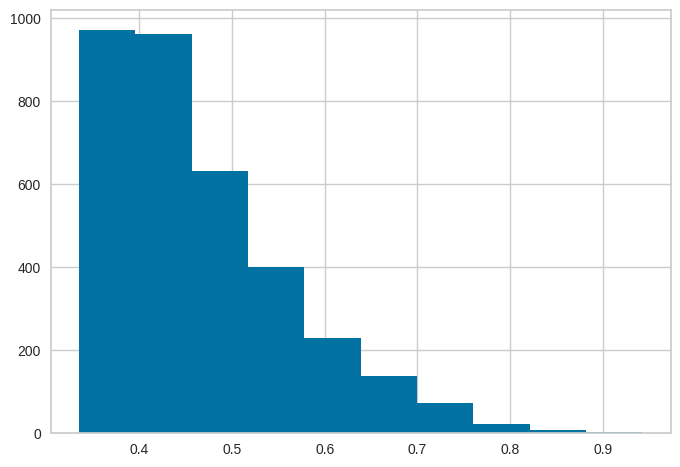

In [58]:
test_pred["prediction_score"].hist()

A large number of predictions are made with a probability lower than 50%. Predictions with around 35% probability are practically not better than random chance. 

If predictions from this model are to be used, it makes sense to focus only on those with a probability higher than 50%.

## Prepare model for deploying

In [59]:
model_lr_final = finalize_model(model_lr_w730_tuned_2)
save_model(model_lr_final, "../models/rolling_model")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['home_win_ratio_roll730D',
                                              'home_draw_ratio_roll730D',
                                              'home_avg_goals_scored_roll730D',
                                              'home_avg_goals_conceded_roll730D',
                                              'away_win_ratio_rol...
                                     transformer=StandardScaler(copy=True,
                                                                with_mean=True,
                                                                with_std=True))),
                 ('actual_estimator',
                  LogisticR